**Project Exam 2, Question 5**

Requirements: 

*   Apply autoencoder on Cifar_10 dataset
*   Pass result to CNN or LSTM or 3-Layers model for classification
*   Repeat after applying PCA on the dataset
*   Compare results of non-PCA and PCA approach



**PCA + CNN**

#### Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import randint

from keras.datasets import cifar10

from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.models import Model
from keras.callbacks import TensorBoard

from keras import regularizers
from keras import backend as K

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

K.set_image_data_format('channels_first')
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#####Make sure the code runs on TF GPU

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num TPUs Available: ", len(tf.config.experimental.list_physical_devices('TPU')))

Num GPUs Available:  1
Num TPUs Available:  0


#### Applying PCA to dataset and reload into CNN model

##### Reload the data and configure PCA

In [ ]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
# perform a transpose reshape from (3,32,32) to (32,32,3)
x_train = x_train.reshape(50000,3,32,32).transpose(0,2,3,1).astype("uint8")
x_test = x_test.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")

In [ ]:
# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('uint8') / 255.
x_test = x_test.astype('uint8') / 255.

In [ ]:
# reshape data from (32,32,3) to (,3072)
x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


#####Apply standard scaler to data

In [ ]:
stdscale_train = x_train
stdscale_test = x_test

In [ ]:
standardscaler = StandardScaler()

In [ ]:
#standardscaler.fit(stdscale_train)
#standardscaler.fit(stdscale_test)

In [ ]:
#stdscale_train = standardscaler.transform(stdscale_train)
#stdscale_test = standardscaler.transform(stdscale_test)

##### PCA configuration

In [ ]:
# building PCA with variance 90% 
pca = PCA()

In [ ]:
# fit PCA to dataset
pca.fit(stdscale_train)
#pca.fit(stdscale_test)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.n_components_

3072

In [ ]:
pca.explained_variance_

array([5.53633226e+01, 2.14265348e+01, 1.27464910e+01, ...,
       1.64690026e-06, 1.60936325e-06, 1.58719044e-06])

In [ ]:
pca.explained_variance_.shape

(3072,)

In [ ]:
# generate transformed dataset
x_train_pca = pca.transform(stdscale_train)
x_test_pca = pca.transform(stdscale_test)

In [ ]:
# reshape data from (,3072) to (32,32,3)
x_train_pca = x_train_pca.reshape(-1, 32,32,3)
x_test_pca = x_test_pca.reshape(-1, 32,32,3)

In [ ]:
print(x_train_pca.shape)
print(x_test_pca.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3), kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 16, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

In [ ]:
# Compile model
epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
historynew = model.fit(x_train_pca, y_train, validation_data=(x_test_pca, y_test), epochs=epochs, batch_size=32)

Epoch 1/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8294 - accuracy: 0.3376 - val_loss: 1.6125 - val_accuracy: 0.4186
Epoch 2/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6393 - accuracy: 0.4109 - val_loss: 1.5323 - val_accuracy: 0.4456
Epoch 3/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5627 - accuracy: 0.4384 - val_loss: 1.4760 - val_accuracy: 0.4661
Epoch 4/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5117 - accuracy: 0.4565 - val_loss: 1.4312 - val_accuracy: 0.4839
Epoch 5/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4701 - accuracy: 0.4721 - val_loss: 1.4183 - val_accuracy: 0.4892
Epoch 6/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4316 - accuracy: 0.4846 - val_loss: 1.3940 - val_accuracy: 0.5000
Epoch 7/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4036 - accuracy: 0.4948 - val_loss: 1.3784 - val_ac

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_test_pca, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 54.23%


#### Accuracy and loss plot

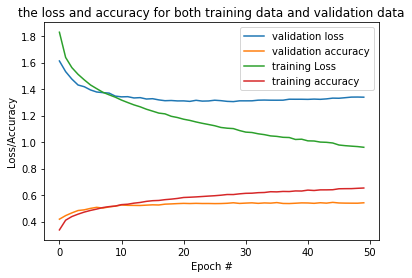

In [ ]:
plt.figure()
plt.plot(np.arange(0, 50), historynew.history["val_loss"], label="validation loss")
plt.plot(np.arange(0, 50), historynew.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, 50), historynew.history["loss"], label="training Loss")
plt.plot(np.arange(0, 50), historynew.history["accuracy"], label="training accuracy")
plt.title("the loss and accuracy for both training data and validation data")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

#### Predict and confirm model performance

In [ ]:
model.save('./savedModel' + '.h5')

In [ ]:
model2 = tf.keras.models.load_model('savedModel.h5')

In [ ]:
class_name = [
  'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
imgarr = [None] * 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


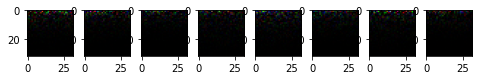

In [ ]:
# plotting 8 reconstructed images that will be predicted
fig = plt.figure(figsize=(8,8))

for i in range(8):
  ax = fig.add_subplot(8, 8, i+1)
  ax.imshow(x_test_pca[i], cmap = plt.cm.bone)

plt.show()

In [ ]:
# predicted labels from CNN for images above
for img in range(0,8):
  predict_class = model2.predict_classes(x_test_pca[[img],:])
  print("predicted for image[" + str(img+1) +"]: " + str(predict_class[0]) + ' ' + str(class_name[predict_class[0]]))

predicted for image[1]: 3 cat
predicted for image[2]: 8 ship
predicted for image[3]: 8 ship
predicted for image[4]: 8 ship
predicted for image[5]: 4 deer
predicted for image[6]: 6 frog
predicted for image[7]: 1 automobile
predicted for image[8]: 6 frog


cat
ship
ship
airplane
frog
frog
automobile
frog


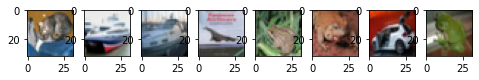

In [ ]:
# plotting original images from above
fig = plt.figure(figsize=(8,8))

for i in range(8):
  ax = fig.add_subplot(8, 8, i+1)
  ax.imshow(x_test[i].reshape(32,32,3), cmap = plt.cm.bone)

  imgarr = y_test[i]
  for j in range(0,len(imgarr)):
    if imgarr[j]== 1:
      print(class_name[j])
      break

plt.show()
